In [407]:
%matplotlib notebook
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold, conv_exp_gauss_heaviside
import glob
from ipyfilechooser import FileChooser

### Choose the json file:

In [421]:
fc = FileChooser('/sf/alvra/data/p18938/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18938/raw/scan_info', filename='', show_hidden='False')

### Next cell: Signal (NO TT CORRECTED) calculated Shot-to-shot and averaged

In [432]:
quantile_laser = 0.5

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp# + [channel_delay_topas]

########################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

Pump_probe_all = []
Pump_probe = []
Pump_probe_avg =[]
Pump_probe_std = []
Pump_probe_std_err = []


for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)
    
    try:
    
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump_probe_std.append(np.nanmean(Laser_diff))
        Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))
                
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
    except:
        print ('skipped run')
    
Delay_mm = Delay_mm[:np.shape(Pump_probe)[0]]
    
Pump_probe_all = np.asarray(Pump_probe_all)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_std = np.asarray(Pump_probe_std)
Pump_probe_std_err = np.asarray(Pump_probe_std_err)

minlen = min(len(i) for i in Pump_probe_all)
def cut(arr, minlen):
    return np.array([i[:minlen] for i in arr])
Pump_probe_all = cut(Pump_probe_all, minlen)

print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(len(scan.files), len(Pump_probe)))
print ("Shape of pump probe data is {}".format(Pump_probe_all.shape))


Step 41 of 41: Processing run_003202
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 401 / 401 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

Quantile range = 0.25 0.75
Loaded 41 files, size of the arrays = 41
Shape of pump probe data is (41, 200)


 ### Plot pump probe signals as a function of delay (stage mm)

<IPython.core.display.Javascript object>


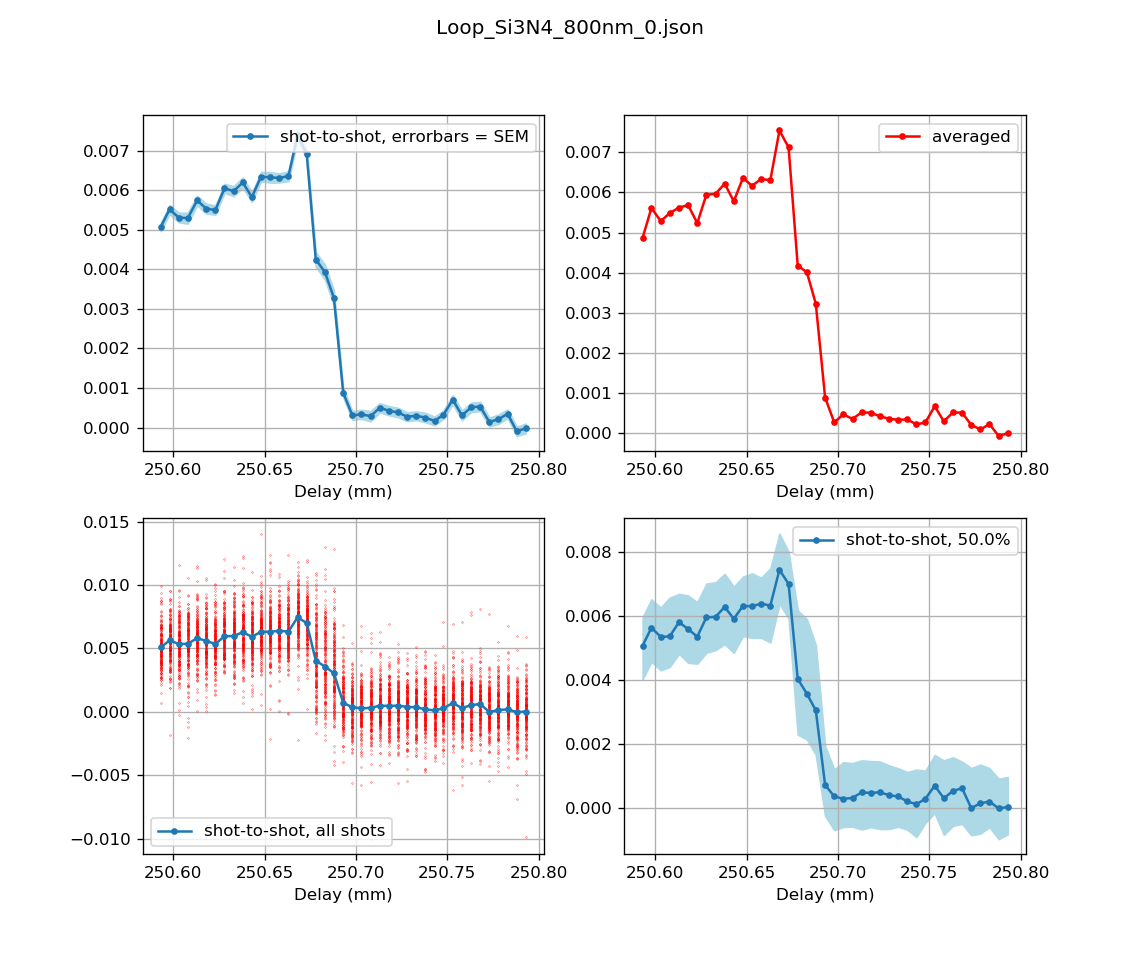

In [394]:
pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

plt.figure(figsize = (9.5,8))
plt.suptitle (fc.selected_filename)

plt.subplot(221)
plt.plot(Delay_mm, Pump_probe_std, label='shot-to-shot, errorbars = SEM', marker='.')
plt.fill_between(np.squeeze(Delay_mm), (Pump_probe_std-Pump_probe_std_err/ np.sqrt(minlen)), (Pump_probe_std+Pump_probe_std_err/ np.sqrt(minlen)), color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc='best')
plt.grid()

plt.subplot(222)
plt.plot(Delay_mm, Pump_probe_avg, label="averaged", color = 'r', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()

plt.subplot(223)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, all shots', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
plt.grid()

plt.subplot(224)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_laser*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
#plt.xlim(190.05,190.1)
plt.grid()

savedir = "/das/work/p17/p17589/Export_PNG/"
#plt.savefig (savedir + 'SiN_5_raw_scan.png')

 ### Extract t0 from the fit 

In [395]:
pp = Pump_probe[:,0]

# Get a rough estimate of timezero in mm from the plot just above.
Timezero = 250.68

Pump_probe_toFit = pp.copy()
Delay_mm_toFit = np.copy(Delay_mm)
Delay_fs_toFit = (Delay_mm_toFit - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

In [396]:
# Now fit with error funciton
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters_mm,extras = curve_fit(conv_exp_gauss_heaviside, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [Timezero, 0.1, 0.006, 0.02,0])
#parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit, Pump_probe_toFit, p0 = [0, 0.06, Timezero, 1])
t0_mm = parameters_mm[0]
width_mm = parameters_mm[3]*2.355

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

Position t0 = 250.68296 mm
Width = 20.0 um


In [397]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_fs_toFit) | np.isnan(Pump_probe_toFit))
parameters_fs,extras = curve_fit(conv_exp_gauss_heaviside, Delay_fs_toFit[index], Pump_probe_toFit[index], p0 = [0, 500, 0, 100,0])
t0_fs = parameters_fs[0]
width_fs = parameters_fs[3]*2.355

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 19.73231 fs
Width = 130.24005 fs


<IPython.core.display.Javascript object>


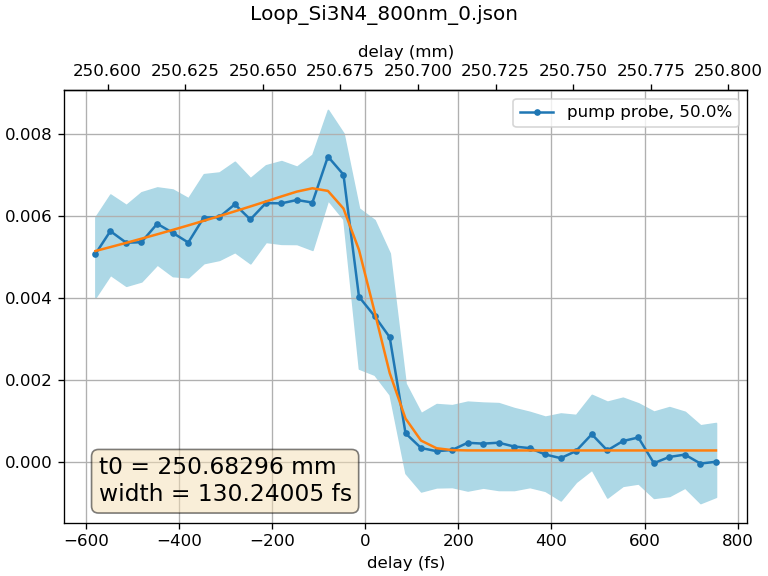

In [398]:
fig, ax = plt.subplots(constrained_layout=True)
#fig, ax = plt.subplots()
plt.suptitle (fc.selected_filename)
plt.plot(Delay_fs_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_fs_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_fs_toFit, conv_exp_gauss_heaviside(Delay_fs_toFit,*parameters_fs))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")

def mm2fs(x):
    return (x-Timezero)*2/(3e8*1e3*1e-15)

def fs2mm(x):
    return Timezero + x * (3e8*1e3*1e-15)/2

secax = ax.secondary_xaxis('top', functions = (fs2mm, mm2fs))
secax.set_xlabel('delay (mm)')

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0 = {} mm'.format(np.round(t0_mm, 5)),
                   r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.show()

<IPython.core.display.Javascript object>


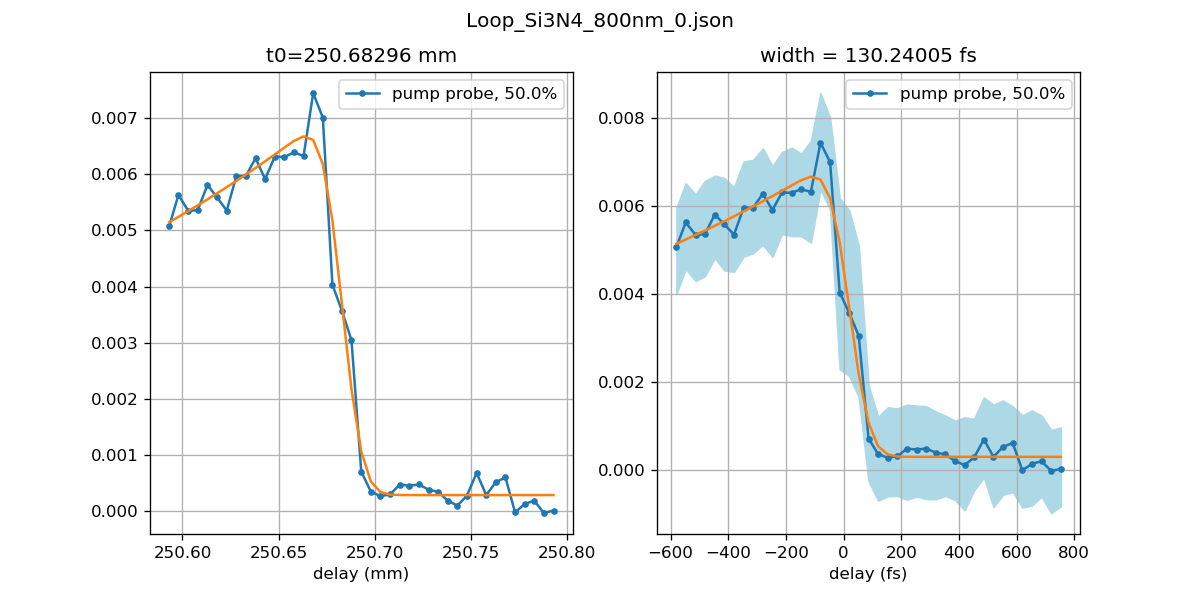

t0 = 250.68296 mm
Time step = 31.99999999992542 fs


In [399]:
#... and the plot with the fit curves

plt.figure(figsize = (10,5))
plt.suptitle (fc.selected_filename)
plt.subplot(121)


plt.plot(Delay_mm_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
# plt.fill_between(np.squeeze(Delay_mm_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_mm_toFit, conv_exp_gauss_heaviside(Delay_mm_toFit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_fs_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_fs_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_fs_toFit, conv_exp_gauss_heaviside(Delay_fs_toFit,*parameters_fs))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_fs, 5))))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
print ('Time step = {} fs'.format((Delay_fs_toFit[1]-Delay_fs_toFit[0])))
plt.show()
#plt.savefig (savedir + 'SiN_5_fit.png')

## Now with TT (PSEN) jitter correction

In [423]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter2 = np.concatenate((signal.tukey(40)[20:40], np.zeros(2027), np.zeros(2047))) # fourier filter for 5um SiN
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

#######################################################################################################3

background_from_fit = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-24-17:04-psen-background.txt')
psen_peak_background = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-24-17:04-psen-peak-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [433]:
quantile_laser = 0.68
Timezero = 250.68296

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_harm,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp # + [channel_Izero117]

########################################################################
import itertools
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

run_number = []
Delays_stage = []
Delay_fs_stage = []
edgePos = []
edgePosRun = []
Pump_probe_all = []
Pump_probe = []
sigtraces = []
peaktraces = []

for i, step in enumerate(scan):
    clear_output(wait=True)
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
    
    resultsPP, results_FEL, _, _ = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)
    
    
    Laser_pump = resultsPP[channel_LaserDiode].pump
    Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
    Laser_unpump = resultsPP[channel_LaserDiode].unpump
    Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    delay_shot = resultsPP[channel_delay_harm].pump
        
    delay_shot_fs = (delay_shot - Timezero)*2/(3e8*1e3*1e-15)
    Delay_fs_stage.append(delay_shot_fs.mean())
    
    #Laser_diff = ((Laser_pump) / (Laser_unpump))
    Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
    #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
    
    Pump_probe_all.append(Laser_diff)
    df_pump_probe = pd.DataFrame(Laser_diff)
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit

        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)

        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, 50)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)

        peak2 = np.argmax(sig5gaussO1 - psen_peak_background) 

        if (peak2 > 500): 
            edgePos.append(peak2)
            Delays_stage.append(np.round(np.mean(delay_shot_fs),4))
            sigtraces.append(sig6)
            peaktraces.append(sig5gaussO1)
            #Pump_probe_all.append(Laser_diff)
        #edgeSig.append(sig5)
        
    edgePosRun.append(np.array(np.nanmean(edgePos)))
Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))

Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)

Pump_probe = np.asarray(Pump_probe)


Step 41 of 41: Processing ['/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_0/run_003202.PVCHANNELS.h5', '/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_0/run_003202.BSDATA.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS                  401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 401 / 401 -> 0% loss
complete channels: 6 / 6 -> 0% incomplete

--------------------------------------------------------------------------------



In [434]:
binsize = 10 # in fs

################################################################################################3
print (np.shape(Pump_probe_all),np.shape(Delays_corr))

#binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
#xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)

binList = np.arange(Delays_corr[0], Delays_corr[-1], binsize)
xAxis = np.arange(Delays_corr[0] + binsize/2, Delays_corr[-1] - binsize/2, binsize)

s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)

(8199,) (8199,)


 ### Extract t0 from the fit 

In [435]:
index = ~(np.isnan(xAxis) | np.isnan(s))
parameters_TTcorr,extras = curve_fit(conv_exp_gauss_heaviside, xAxis[index], s[index], p0 = [0, 500, 0, 100,0])
t0_TTcorr = parameters_TTcorr[0]
width_TTcorr = parameters_TTcorr[3]*2.355

print("Position t0_corr = {} fs relative to {} mm".format(np.round(t0_TTcorr,5), Timezero))
print("Width =",np.abs(np.round(width_TTcorr,5)),"fs")

Position t0_corr = 58.38181 fs relative to 250.68296 mm
Width = 62.13424 fs


<IPython.core.display.Javascript object>


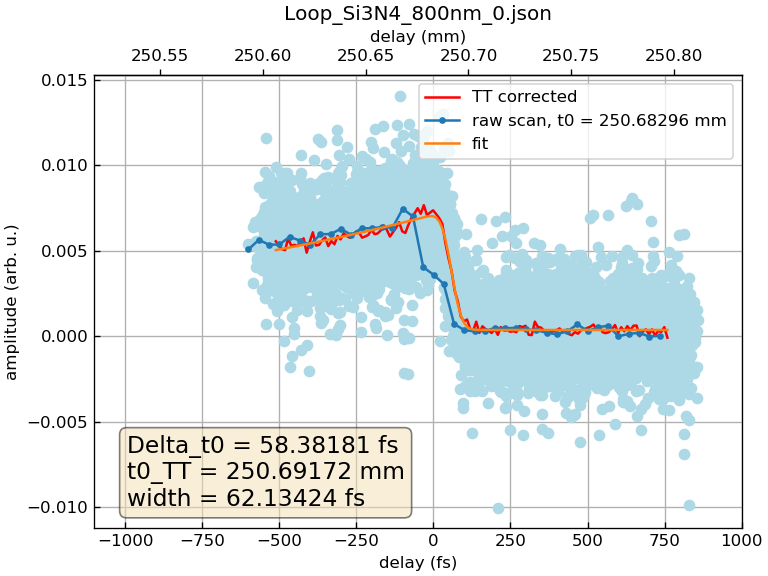

Position t0_TT = 250.69171727086766 mm


In [436]:
pp_uncorrected = Pump_probe[:,0]

fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')
plt.plot(Delays_corr, Pump_probe_all, 'o', color='lightblue')
plt.plot(xAxis, s, color='red', label = 'TT corrected')
plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.plot(Delay_fs_stage, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(Timezero))
plt.plot(xAxis, conv_exp_gauss_heaviside(xAxis,*parameters_TTcorr), label = 'fit')
plt.legend (loc = 'upper right')

secax = ax.secondary_xaxis('top', functions = (fs2mm, mm2fs))
secax.set_xlabel('delay (mm)')

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'Delta_t0 = {} fs'.format(np.round(t0_TTcorr, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2,5)),
            r'width = {} fs'.format(np.abs(np.round(width_TTcorr, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlim(-1100, 1000)
#plt.ylim(-0.01, 0.01)

plt.grid()
plt.show()

print("Position t0_TT = {} mm".format(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2))

<IPython.core.display.Javascript object>


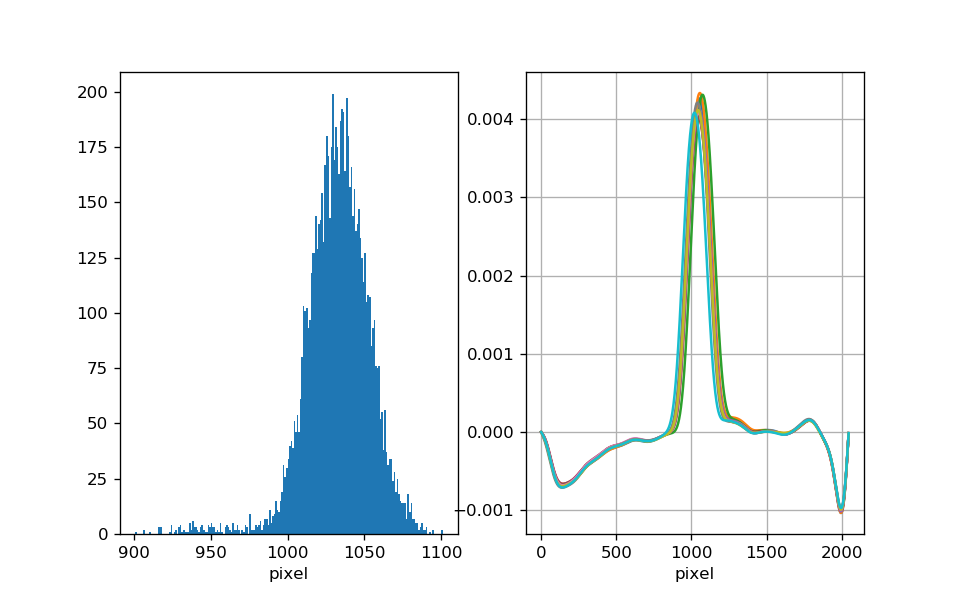

Peak of the histogram is at 1031.9356146417074 pixels
Offset compared to p0 = 1024 pixel is -15.8157469620796 fs
Jitter, i.e. width (std) of the histogram 42.18397711022602 fs


In [224]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(edgePos, bins=200)
#plt.xlim(900,1100)
plt.xlabel('pixel')

plt.subplot(122)
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(pixelNum, peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Peak of the histogram is at {} pixels".format(np.mean(edgePos)))
print("Offset compared to p0 = {} pixel is {} fs".format(p0, ((p0 - np.mean(edgePos))*px2fs)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(edgePos)*px2fs))

# Loop over several runs

In [378]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p18938/raw/scan_info/Loop*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:7] + datafiles [8:16] + datafiles [17:24] + datafiles [25:34] + datafiles [35:65] + datafiles [66:78] + datafiles [80:88] + datafiles [89:]
datafiles[:98]

['/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_0.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_1.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_2.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_3.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_4.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_5.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_6.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_7.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_8.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_9.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_10.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_11.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_12.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_13.json',
 '/sf/alvra/data/p18938/raw/scan_info/Loop_Si3N4_800nm_14.json',
 '/sf/alvra/data/p18938/raw/scan_in

## without TT correction

In [379]:
quantile_laser = 0.68

Timezero_loop = 250.68296

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_delay_topas]

########################################################################
from sfdata import SFScanInfo

width_fs_loop = []
t0_fs_loop =[]
timestamp = []
scan_number = []

for json_file in datafiles[:98]:
    print (json_file)
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    scan = SFScanInfo(json_file)
    Delay_mm = scan.readbacks
    
    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    
    with h5py.File(scan.files[0][1], 'r') as fn:
        timestamp.append(fn[channel_Events]['timestamp'][()])
    
    for i, step in enumerate(scan):
        check_files_and_data(step)
        clear_output(wait=True)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
    
        resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)
            
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
        #Izero_FEL = results_FEL[channel_Izero117]
        
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
        Pump_probe_std.append(np.nanmean(Laser_diff))
        Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))  
        
    Pump_probe_all = np.asarray(Pump_probe_all)
    Pump_probe = np.asarray(Pump_probe)
    Pump_probe_avg = np.asarray(Pump_probe_avg)
    Pump_probe_std = np.asarray(Pump_probe_std)
    Pump_probe_std_err = np.asarray(Pump_probe_std_err)
    
    minlen = min(len(i) for i in Pump_probe_all)
    def cut(arr, minlen):
        return np.array([i[:minlen] for i in arr])
    Pump_probe_all = cut(Pump_probe_all, minlen)


    Delay_mm = np.asarray(Delay_mm)
    
    pp_loop = Pump_probe[:,0]
    Delay_fs_toFit_loop = (Delay_mm - Timezero_loop)*2/(3e8*1e3*1e-15) 
    
    index = ~(np.isnan(Delay_fs_toFit_loop) | np.isnan(pp_loop))
    parameters_fs_loop,extras = curve_fit(conv_exp_gauss_heaviside, Delay_fs_toFit_loop, pp_loop, p0 = [0, 500, 0, 100,0])
    
    t0_fs_loop.append(parameters_fs_loop[0])
    width_fs_loop.append(np.abs(parameters_fs_loop[3])*2.355)
    
scan_number = np.asarray(scan_number)    

Step 41 of 41: Processing ['/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_97/run_007180.PVCHANNELS.h5', '/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_97/run_007180.BSDATA.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS    400 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 401 / 401 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 400 / 401 -> 0% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------



<IPython.core.display.Javascript object>


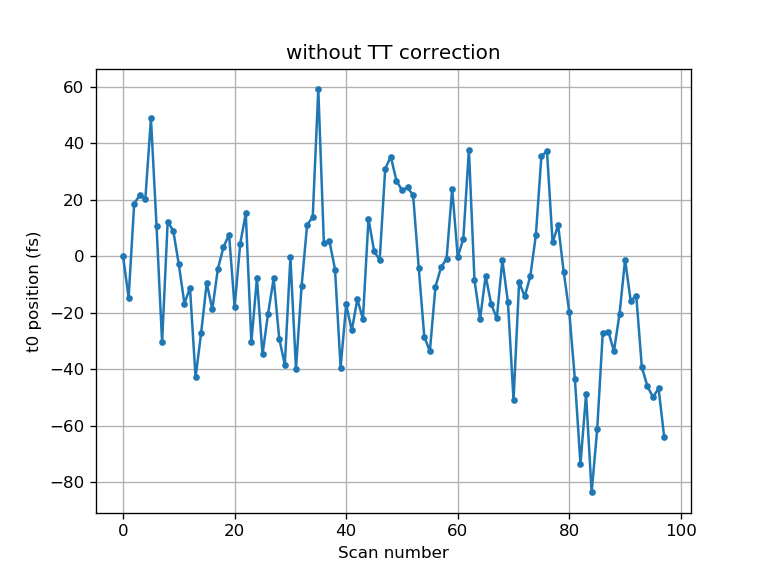

In [390]:
scan_number_int = [np.int(scan_n) for scan_n in scan_number]
# np.array(scan_number_int)
#scan_axis = np.arange(0,100,1)
plt.figure()
plt.title('without TT correction')
plt.plot(scan_number_int, t0_fs_loop, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('t0 position (fs)')
#plt.ylim(-80,80)
plt.grid()
plt.show()

## with TT correction

In [437]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter2 = np.concatenate((signal.tukey(40)[20:40], np.zeros(2027), np.zeros(2047))) # fourier filter for 5um SiN
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

#######################################################################################################3

background_from_fit = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-24-17:04-psen-background.txt')
psen_peak_background = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-24-17:04-psen-peak-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [438]:
quantile_laser = 0.68
binsize = 10 # in fs
Timezero_loop = 250.68296

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_harm,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp # + [channel_Izero117]

########################################################################
from sfdata import SFScanInfo
import itertools

run_number = []
pid_number = []
width_fs_loop_TT = []
t0_fs_loop_TT =[]
edgePosRuns = []
edgePosScans = []
timestamp_scan = []
timestamp_run = []
scan_number = []

for json_file in datafiles[:98]:
    print (json_file)
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    scan = SFScanInfo(json_file)
    Delay_mm = scan.readbacks
    
    Pump_probe_all_loop = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Delay_mm = []
    Delays_stage_loop = []
    Delay_fs_stage = []
    edgePos = []
    sigtraces = []
    peaktraces = []
    
    with h5py.File(scan.files[0][1], 'r') as fn:
        timestamp.append(fn[channel_Events]['timestamp'][()])
    
    for i, step in enumerate(scan):
        edgePos_singleRun = []
        check_files_and_data(step)
        clear_output(wait=True)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
    
        resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)
            
        pid_number.append(pids_pump[0])
        #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        #load_YAG_events(str(data['scan_files'][i][0]))
        
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
        sig = resultsPP[channel_PSEN_signal].pump
        back = resultsPP[channel_PSEN_bkg].pump
        delay_shot = resultsPP[channel_delay_harm].pump
        
        delay_shot_fs = (delay_shot - Timezero_loop)*2/(3e8*1e3*1e-15)
        Delay_fs_stage.append(delay_shot_fs.mean())
        
        #Izero_FEL = results_FEL[channel_Izero117]
        
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
        Pump_probe_all_loop.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
        for k in range(0, len(sig)):
            # background subtraction
            sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
            # interpolate to get evenly sampled in frequency space
            sig3inter = interp1d(nus, sig2, kind='cubic')
            sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
            sig4power = np.abs(np.fft.fft(sig4))**2

            # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
            sig4fft = np.fft.fft(sig4)
            sig4filtered = sig4fft * filter
            sig4inverse = np.fft.ifft(sig4filtered)
            sig4invreal = 2 * np.real(sig4inverse)
            
            sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
            sig5 = sig4inter(nus)
            sig5gaussO0 = gaussian_filter1d(sig5, 50)
            sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
            sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
    
            peak2 = np.argmax(sig5gaussO1 - psen_peak_background)
        
            if (peak2 > 500): 
                edgePos.append(peak2)
                edgePos_singleRun.append(peak2)
                Delays_stage_loop.append(np.round(np.mean(delay_shot_fs),4))
                sigtraces.append(sig6)
                peaktraces.append(sig5gaussO1)
            #Pump_probe_all.append(Laser_diff)
            #edgeSig.append(sig5)
            
        edgePosRuns.append(np.array(np.nanmean(edgePos_singleRun)))
        
    edgePosScans.append(np.nanmean(edgePosRuns))

    
    Pump_probe_all_loop = list(itertools.chain.from_iterable(Pump_probe_all_loop))
    Delays_corr_loop = Delays_stage_loop + ((p0 - np.array(edgePos))*px2fs)
        
    print (np.shape(Pump_probe_all_loop),np.shape(Delays_corr_loop))
    
    binList_loop = np.arange(Delays_corr_loop[0], Delays_corr_loop[-1], binsize)
    #xAxis_loop = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)
    xAxis_loop = np.arange(Delays_corr_loop[0] + binsize/2, Delays_corr_loop[-1] - binsize/2, binsize)

    
    s_loop, binEdges, binNumber = binned_statistic(Delays_corr_loop, Pump_probe_all_loop, statistic='mean', bins=binList_loop)
    
    index = ~(np.isnan(xAxis_loop) | np.isnan(s_loop))
    parameters_TTcorr_loop,extras = curve_fit(conv_exp_gauss_heaviside, xAxis_loop[index], s_loop[index], p0 = [0, 500, 0, 100,0])
    t0_TTcorr = parameters_TTcorr_loop[0]
    width_TTcorr = parameters_TTcorr_loop[3]*2.355
    
    t0_fs_loop_TT.append(t0_TTcorr)
    width_fs_loop_TT.append(width_TTcorr)
    
    

Step 41 of 41: Processing ['/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_97/run_007180.PVCHANNELS.h5', '/sf/alvra/data/p18938/raw/scan_data/Loop_Si3N4_800nm_97/run_007180.BSDATA.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS                  400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               400 / 400 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 400 / 400 -> 0% loss
complete channels: 6 / 6 -> 0% incomplete

--------------------------------------------------------------------------------

(8199,) (8199,)


In [441]:
np.asarray(edgePosRuns)

array([ 981.715     ,  986.08      , 1007.115     , ..., 1025.685     ,
       1023.995     , 1020.32663317])

<IPython.core.display.Javascript object>


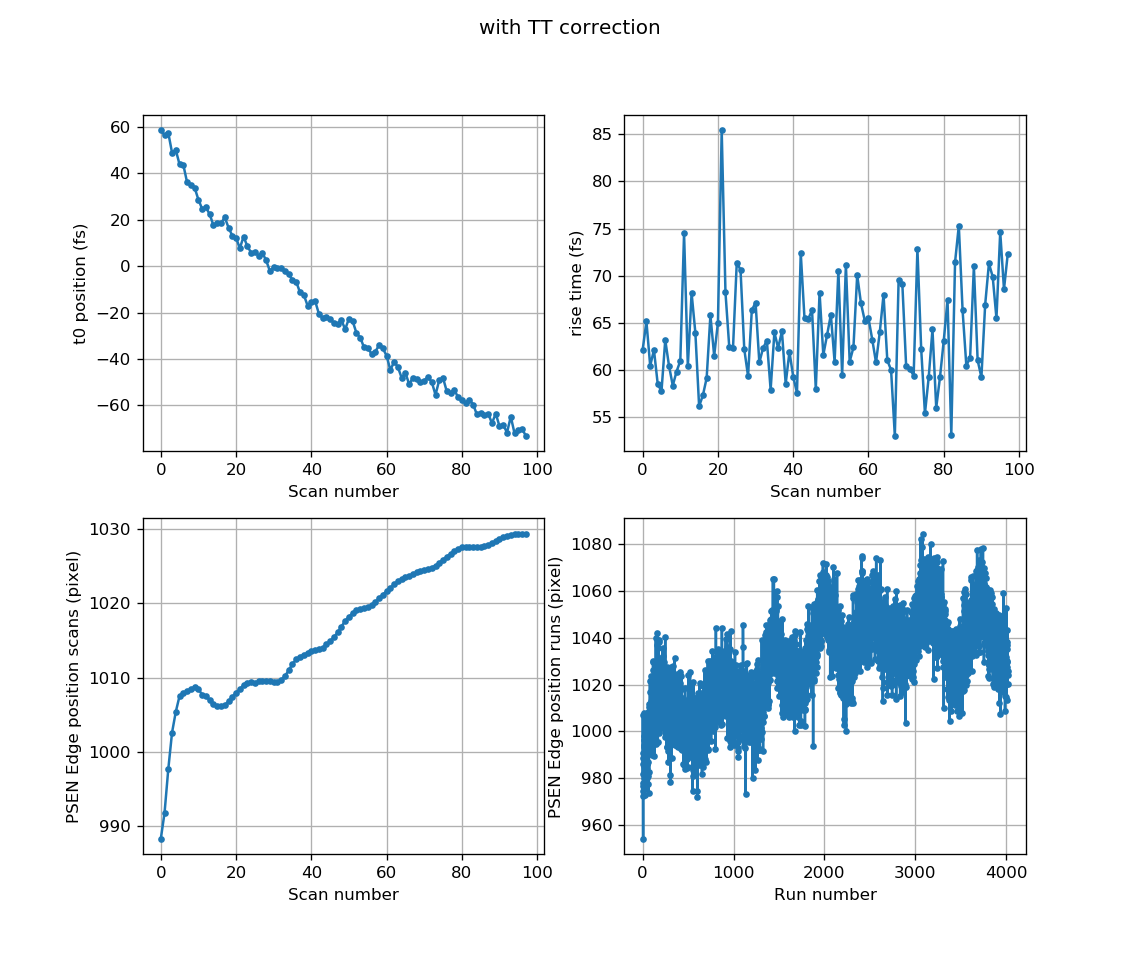

In [445]:
plt.figure(figsize = (9.5,8))
plt.suptitle('with TT correction')

plt.subplot(221)
plt.plot(t0_fs_loop_TT, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('t0 position (fs)')
#plt.ylim(-80,80)
plt.grid()

plt.subplot(222)
plt.plot(width_fs_loop_TT, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('rise time (fs)')
#plt.ylim(-80,80)
plt.grid()

plt.subplot(223)
plt.plot(edgePosScans, marker = '.')
plt.xlabel('Scan number')
plt.ylabel('PSEN Edge position scans (pixel)')
#plt.ylim(-80,80)
plt.grid()

plt.subplot(224)
plt.plot(edgePosRuns, marker = '.')
plt.xlabel('Run number')
plt.ylabel('PSEN Edge position runs (pixel)')
#plt.ylim(-80,80)
plt.grid()


plt.show()

In [80]:
quantile_laser = 0.68

Timezero_loop = 176.39254
binsize = 10 # in fs
saveFileName = '_Loop_N3'

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_topas,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp # + [channel_Izero117]

########################################################################
import itertools

run_number = []
pid_number = []
width_fs_loop_TT = []
t0_fs_loop_TT =[]
edgePosRuns = []
edgePosScans = []
timestamp_scan = []
timestamp_run = []


patch = datafiles[:8] + datafiles [9:34]

for json_file in patch:
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])
    #numFiles = 3
    print ("Processing",numFiles,"files")

    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Delay_mm = []
    Delays_stage = []
    Delay_fs_stage = []
    edgePos = []
    sigtraces = []
    peaktraces = []
    
    temp = data['scan_files'][-1]   
    with h5py.File(temp[0], 'r') as fn:
            timestamp_scan.append(fn['general/created'][()])

    for i in range(0,numFiles):
        edgePos_singleRun = []
        filename = (data['scan_files'][i])
        testdata = check_files_and_data(filename[0])
        #avoid = (int(filename[0].split('/')[-1].split('.')[0].split('_')[-1]) != 4377)
        
        if (testdata):# and (avoid): # and (i!=16):
            clear_output(wait=True)
            
            with h5py.File(filename[0], 'r') as fn:
                timestamp_run.append(fn['general/created'][()])
       
            print("step",i+1,"of",numFiles,": Processing %s" % (filename))
            run_number.append(int(filename[0].split('_')[-1].split('.')[0]))
        
            resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
            
            pid_number.append(pids_pump[0])
            #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
            #load_YAG_events(str(data['scan_files'][i][0]))
        
            Laser_pump = resultsPP[channel_LaserDiode].pump
            Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
            Laser_unpump = resultsPP[channel_LaserDiode].unpump
            Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
            
            sig = resultsPP[channel_PSEN_signal].pump
            back = resultsPP[channel_PSEN_bkg].pump
            delay_shot = resultsPP[channel_delay_topas].pump
            
            delay_shot_fs = (delay_shot - Timezero_loop)*2/(3e8*1e3*1e-15)
            Delay_fs_stage.append(delay_shot_fs.mean())
        
            #Izero_FEL = results_FEL[channel_Izero117]
        
            Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
            Pump_probe_all.append(Laser_diff)
            df_pump_probe = pd.DataFrame(Laser_diff)
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
        
            for k in range(0, len(sig)):
                # background subtraction
                sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
                # interpolate to get evenly sampled in frequency space
                sig3inter = interp1d(nus, sig2, kind='cubic')
                sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
                sig4power = np.abs(np.fft.fft(sig4))**2

                # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
                sig4fft = np.fft.fft(sig4)
                sig4filtered = sig4fft * filter
                sig4inverse = np.fft.ifft(sig4filtered)
                sig4invreal = 2 * np.real(sig4inverse)
            
                sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
                sig5 = sig4inter(nus)
                sig5gaussO0 = gaussian_filter1d(sig5, 50)
                sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
                sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
    
                peak2 = np.argmax(sig5gaussO1)
        
                #if (peakxcorr > 0) & (peak2.max() > 0.05): 
                edgePos.append(peak2)
                edgePos_singleRun.append(peak2)
                Delays_stage.append(np.round(np.mean(delay_shot_fs),4))
                sigtraces.append(sig6)
                peaktraces.append(sig5gaussO1)
                #Pump_probe_all.append(Laser_diff)
                #edgeSig.append(sig5)
            
            edgePosRuns.append(np.array(np.nanmean(edgePos_singleRun))) 
    edgePosScans.append(np.nanmean(edgePosRuns))
            
    Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))
    Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)
        
    print (np.shape(Pump_probe_all),np.shape(Delays_corr))
    
    binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
    xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)
    
    s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)
    
    index = ~(np.isnan(xAxis) | np.isnan(s))
    parameters_TTcorr,extras = curve_fit(errfunc_fwhm, xAxis[index], s[index], p0 = [0, 0.2, 0, 100])
    t0_TTcorr = parameters_TTcorr[2]
    width_TTcorr = parameters_TTcorr[3]
    
    t0_fs_loop_TT.append(t0_TTcorr)
    width_fs_loop_TT.append(width_TTcorr)
    
savedir = '/das/work/p18/p18386/claudio/'

hf = h5py.File(savedir + saveFileName, 'w')
hf.create_dataset('pulse_ids', data=pid_number)
hf.create_dataset('timestamp_scan', data=timestamp_scan)
hf.create_dataset('timestamp_run', data=timestamp_run)

hf.create_dataset('edgePosRuns', data=edgePosRuns)
hf.create_dataset('edgePosScans', data=edgePosScans)

hf.create_dataset('t0_TT', data=t0_fs_loop_TT)
hf.create_dataset('width_TT', data=width_fs_loop_TT)

hf.close()

step 76 of 76 : Processing ['/sf/alvra/data/p18386/raw/scan_data/Loop_YAG_hve_topas_N3_33/run_010008.BSREAD.h5']
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 500 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     500 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 500 / 501 -> 0% loss
complete channels: 4 / 6 -> 33% incomplete

--------------------------------------------------------------------------------

(18962,) (18962,)


In [109]:
fff = loaddir = '/das/work/p18/p18386/claudio/_Loop.h5'

with h5py.File(fff, 'r') as fn:
        timestamp = fn['timestamp'][:]
        t0_fs_loop_TT = fn['t0_TT'][:]

In [110]:
from datetime import datetime
import matplotlib.dates

def conv(ts):
    dt = datetime.strptime(ts.decode('UTF-8'), "%Y-%m-%d %H:%M:%S.%f")
    mpl_date = matplotlib.dates.date2num(dt)
    return mpl_date

timestamp_plot = [conv(ts) for ts in timestamp]

<IPython.core.display.Javascript object>


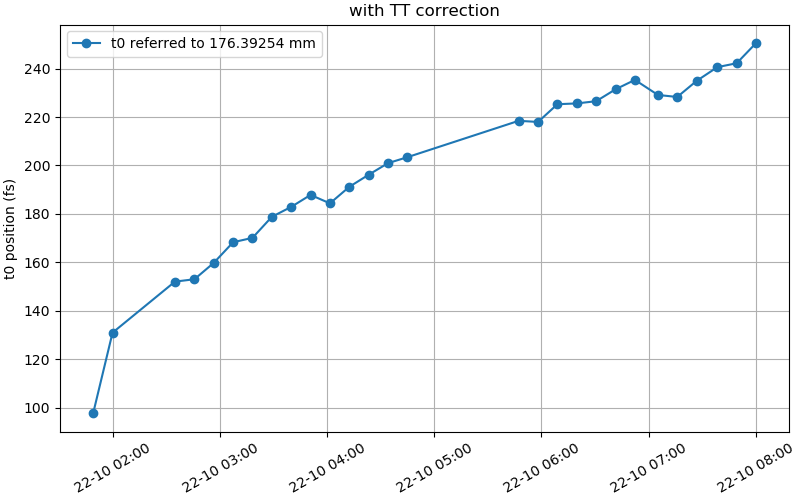

In [111]:
fig, ax = plt.subplots(constrained_layout=True)

fig.set_size_inches(8,5)
plt.title('with TT correction')
plt.plot_date(timestamp_plot, t0_fs_loop_TT, ls = '-', label ='t0 referred to {} mm'.format(Timezero_loop))
plt.legend(loc='best')

hfmt = matplotlib.dates.DateFormatter('%d-%m %H:%M')

ax.xaxis.set_major_locator(matplotlib.dates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)

plt.xticks(rotation = 30)
plt.ylabel('t0 position (fs)')
plt.grid()
plt.show()

plt.savefig (savedir + 'Loop_hve_N1')

# From here with TT (PALM) jitter correction

In [9]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
#DIRcalib = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/'
DIRcalib = '/sf/alvra/data/p17589/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-07-03_10:44:41.palm_etof'

energyFrom =  2200
energyTo =    2500
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))


palm.load_etof_calib(CalibrationFn)

### Choose the json file:

In [10]:
fc = FileChooser('/sf/alvra/data/p17589/res/scan_info/') #this is for slic
#fc = FileChooser('/sf/alvra/data/p17589/raw/scan_info/')  #this is for RC
display(fc)

FileChooser(path='/sf/alvra/data/p17589/res/scan_info', filename='', show_hidden='False')

In [44]:
channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero122, channel_delay_harm, channel_PALM_streak, channel_PALM_unstreak]

quantile_laser = 0.5
minlen = 1497
ev2fsCalib= -3.1824981756907595    # scan0000_2020-07-03-thz-time-calib-slic_004
Timezero = 190.10554              # This is from above
#modulo = 2                        # This is for FEL/50Hz -- laser/100Hz
                
########################################################################


###########################################################################################
json_file = fc.selected
#json_file = DIR_json + scan_name + scan_range + ".json"
#json_file = DIR_json + "scan0010_2020-07-03-SiN4_5_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
Pump_probe_avg =[]
Pump_probe_all = []
Delays_stage_mm = []
Delays_PALM_all = []

for i in range(0,numFiles):
    filename = (data['scan_files'][i])
    testdata = check_files_and_data(filename[0])

    if (testdata):# and (i!=12):
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    
        results_pp, results_FEL, FEL_reprate, laser_reprate = \
        load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
        Laser_pump = results_pp[channel_LaserDiode].pump
        Laser_unpump = results_pp[channel_LaserDiode].unpump
        Laser_ref_pump = results_pp[channel_Laser_refDiode].pump
        Laser_ref_unpump = results_pp[channel_Laser_refDiode].unpump
        Event_code = results_pp[channel_Events].unpump
        
        TOF = results_FEL[channel_PALM_streak]
        uTOF = results_FEL[channel_PALM_unstreak]
        Izero_FEL = results_FEL[channel_Izero122]
        Delay_shot = results_FEL[channel_delay_harm]
        
        prep_data = {"0":uTOF, "1":TOF}
        delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process(prep_data, debug=True, peak='com')
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        
        Laser_diff = Laser_diff[:minlen]
        delays_PALM_fs = delays_PALM_fs[:minlen]
        Izero_FEL = Izero_FEL[:minlen]
        
        fullArraySize = len(delays_PALM_fs)
        #delays_PALM_fs = delays_PALM_fs[:fullArraySize]
        #Izero_FEL = Izero_FEL[:fullArraySize]
        beamOK = (Izero_FEL > 2)
            
        delays_beamOK = delays_PALM_fs[beamOK]
        NumberOK = len(delays_beamOK) 
        shots2pad = fullArraySize - NumberOK
        try:       
            delays_beamOK = np.pad(delays_beamOK, (0, shots2pad), constant_values=np.NaN)
            Laser_diff = np.pad(Laser_diff, (0, len(delays_beamOK)-len(Laser_diff)), constant_values=np.NaN)
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, light shots are {}, need to pad {} shots' \
                   .format(laser_reprate, FEL_reprate, NumberOK, shots2pad))
        except:
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, they are not commensurate, cannot pad. Keep {} light shots' \
                   .format(laser_reprate, FEL_reprate, NumberOK))
                       
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.quantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        #Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delays_stage_mm.append([np.median(Delay_shot)])
        
        Delays_PALM_all.append(delays_beamOK)
        
        Pump_probe_all.append(Laser_diff)
        

Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)
        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))

step 51 of 51 : Processing /sf/alvra/data/p17589/raw/scan_data/scan0010_2020-07-03-SiN4_5/scan0010_2020-07-03-SiN4_5_step0050/run_001152.*.h5
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   1501 / 3001 -> 50% loss ▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   1501 / 3001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     1501 / 3001 -> 50% loss ▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    3000 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1500 / 3001 -> 50% loss

--------------------------------------------------------------------------------

Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 1496, need to pad 1 shots
PBPS data of the last step have 1497 shots, 

In [45]:
print (Delays_PALM_all.shape, Pump_probe_all.shape, Delays_stage_mm.shape)

(51, 1497) (51, 1497) (51, 1)


<IPython.core.display.Javascript object>


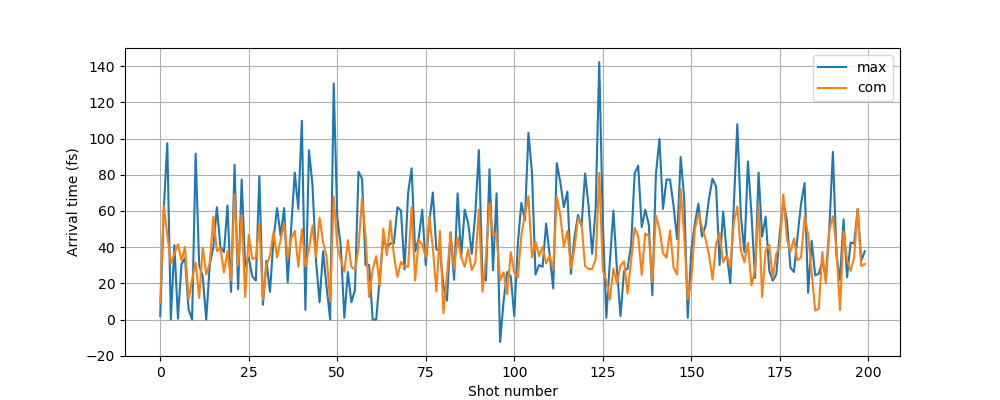

In [56]:
#delays_max = np.copy(Delays_PALM_all.ravel())
plt.figure(figsize=(10,4))
plt.plot (delays_max[0:200], label = 'max')
plt.plot (delays_com[0:200], label = 'com')
plt.legend(loc='best')
plt.xlabel('Shot number')
plt.ylabel('Arrival time (fs)')
plt.grid()
plt.show()
plt.savefig (savedir + 'SiN_5_TT_comp_MAXvsCOM.png')

In [57]:
for i in range (Delays_PALM_all.shape[0]):
    print (i, np.nanmedian(Delays_PALM_all[i,:]))
    
np.nanmean(Delays_PALM_all)

0 40.35072403628929
1 34.86412790482618
2 44.06950033743856
3 44.940628096864124
4 40.10369703049535
5 40.17376515933261
6 36.934894499513504
7 29.943688729447352
8 32.35499757104007
9 27.79932794490612
10 25.671543016601564
11 29.623838926886073
12 29.421636813085634
13 33.75342271275525
14 31.985051670899274
15 27.17755364610991
16 30.684858770335055
17 31.242061667178167
18 37.19486758161104
19 31.61335819976801
20 25.25491148514783
21 31.03805753779881
22 28.189599730399816
23 29.358373358414468
24 29.743156024715333
25 25.538203169554997
26 21.40001566461083
27 20.334143297328808
28 28.795220404484212
29 23.568857780668292
30 14.86855541800184
31 19.574073566043232
32 20.579233301764425
33 24.465725856685623
34 22.1487709127296
35 15.86877103593267
36 14.763327560527378
37 15.05157386848534
38 24.046417823083353
39 24.346932216227074
40 27.79309005740829
41 34.51280066437353
42 25.31405882069463
43 21.192415770212985
44 28.19796083334588
45 27.751322983056752
46 26.789310035789708

28.030846417728615

<IPython.core.display.Javascript object>


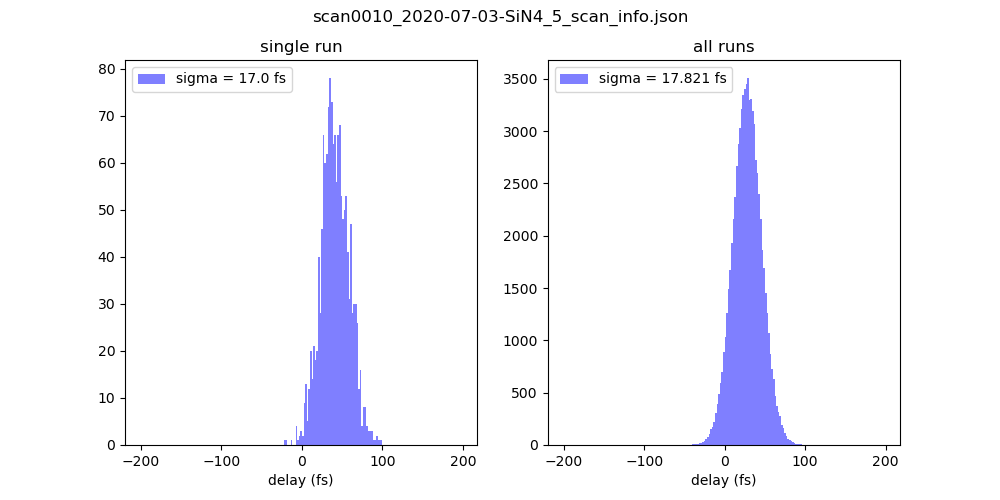

In [46]:
plt.figure(figsize=(10,5))
plt.suptitle(fc.selected_filename)

plt.subplot(121)
#plt.hist((Delays_PALM_all[0]-np.nanmean(Delays_PALM_all[0,:])), bins =np.arange(-200,200,2), facecolor='blue', \
#         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all[0,:]-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.hist((Delays_PALM_all[0]), bins =np.arange(-200,200,2), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all[0,:])), 3), alpha=0.5)

plt.title('single run')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

plt.subplot(122)
#plt.hist((Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all.ravel())), bins =np.arange(-200,200,5), facecolor='blue', \
#         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.hist(((Delays_PALM_all.ravel())), bins =np.arange(-200,200,2), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()), 3)), alpha=0.5)
plt.title('all runs')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()
plt.savefig (savedir + 'SiN_5_TT_hist_MAX.png')

In [47]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs - ((DelaysPALM_fs)-(np.nanmean(DelaysPALM_fs)))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    
    digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    signalProc = []
    signalProc_Q = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i+1
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        df_signal = pd.DataFrame(Signal[ind])
        signalProc_Q.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
        
    signalProc= np.array(signalProc)
    signalProc_Q= np.array(signalProc_Q)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)

    return binsCentre, CorrectedTime, signalProc, signalProc_Q, signalProcSS, Num_points

In [51]:
quantile_reBin = 0.5
reBin_factor = 2

############################################################################

BinsCentre, CorrectedTime, Signal, Signal_Q, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

(51, 1497) (51, 1) (76347,)


<IPython.core.display.Javascript object>


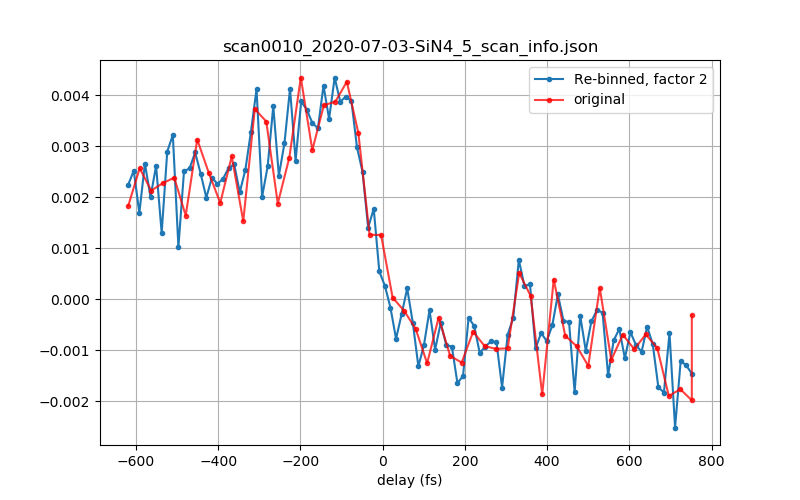

In [52]:
sig = Signal
plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}'.format(reBin_factor), marker = '.')

plt.plot(Delays_stage_fs, pp, label='original', color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
#plt.xlim(-700, 300)
plt.show()
plt.savefig (savedir + 'SiN_5_TT_rebin_factor2_com.png')

<IPython.core.display.Javascript object>


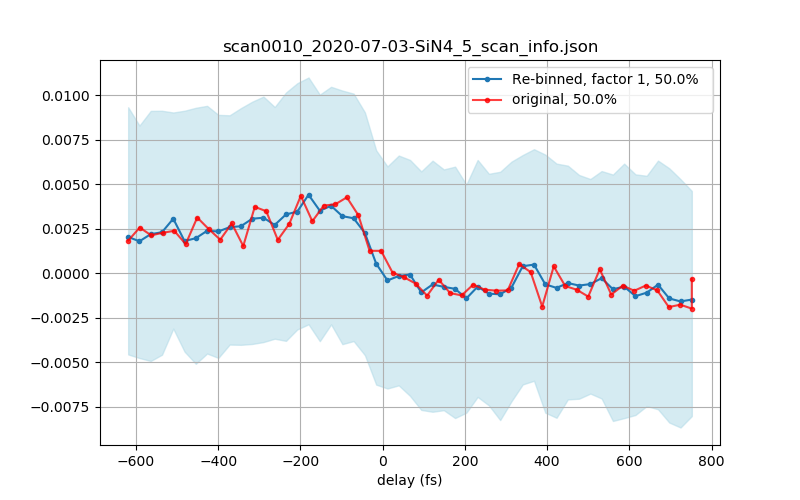

In [21]:
sig = Signal_Q[:,0]
err_sig_low = Signal_Q[:,1]
err_sig_high = Signal_Q[:,2]

plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}, {}%  '.format(reBin_factor, quantile_reBin*100), marker = '.')
plt.fill_between(BinsCentre.ravel(), err_sig_low, err_sig_high, color='lightblue',  alpha = 0.5)

plt.plot(Delays_stage_fs, pp, label='original, {}%'.format(quantile_laser*100), color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
plt.show()
#plt.savefig (savedir + scan_name + 'TT_rebin.png')

In [50]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(BinsCentre.ravel()) | np.isnan(sig))
parameters_fs,extras = curve_fit(errfunc_fwhm, BinsCentre.ravel()[index], sig[index], p0 = [0, 0.2, 0, 100])
t0_fs = parameters_fs[2]
width_fs = parameters_fs[3]

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = -21.33079 fs
Width = 50.31587 fs


<IPython.core.display.Javascript object>


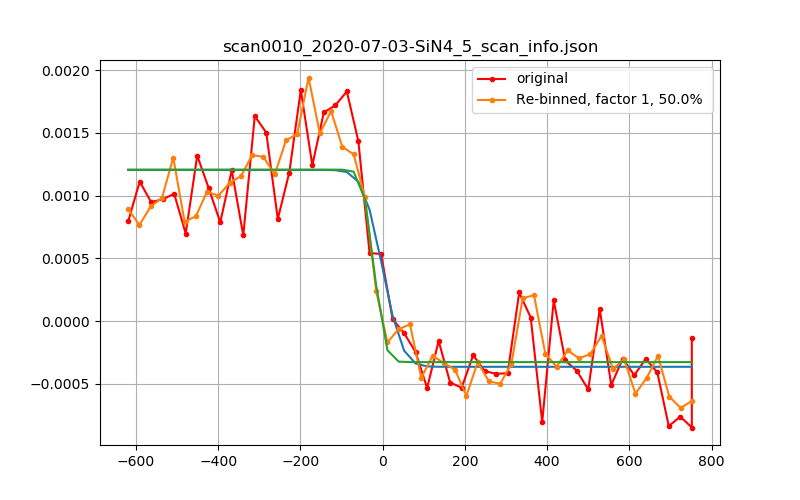

<function matplotlib.pyplot.show(*args, **kw)>

In [51]:
plt.figure(figsize = (8,5))
plt.title (fc.selected_filename)

plt.plot (Delays_stage_fs, pp, marker = '.', label ='original', color = 'r')
plt.plot(Delays_stage_fs, errfunc_fwhm(Delay_ps_toFit,*parameters_ps))

plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}, {}% '.format(reBin_factor, quantile_reBin*100), marker = '.')
plt.plot (BinsCentre.ravel(), errfunc_fwhm(BinsCentre.ravel(), *parameters_fs))
plt.grid()
plt.legend(loc='best')
plt.show



In [ ]:
time_zero =  149.6658   #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 3        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

In [77]:
offset_space = 176392.540 - 176383.73926478235       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 8.800735217664624 um corresponds to an offset of 58.6716 fs


In [3]:
offset_time = 100e6      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 100000000.0 fs corresponds to an offset of 15000000.0 um


In [ ]:
195.2-(105.9-88.35)

In [ ]:
# Check if the condition on the intensity makes sense by looking at the total histogram. §

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()